In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

GRAPH_SIZE = 10

In [2]:
def show_graph(graph):
    if type(graph) is np.ndarray:
        graph = nx.from_numpy_matrix(input_graph)
    nx.draw(graph, with_labels=True)
    plt.axis('equal')
    
def import_graph(filepath):
    graph = None
    f = open(filepath, 'r')
    lines = f.readlines()
    for i in lines:
        line = i.strip('\n').split(' ')
        if line[0] == 'p':
            graph = np.zeros((int(line[2]), int(line[2])), dtype = int)
        elif line[0] == 'e':
            graph[int(line[1])-1][int(line[2])-1] = 1
            
    return graph
        


In [3]:
def initialize_population(adj_matrix, pop_size):
    population = []
    graph = nx.from_numpy_matrix(adj_matrix)
    
    for i in range(0, pop_size):
        individual = []
        random_node = random.choice(list(graph.nodes))
        individual.append(random_node)
        nodes = list(graph[random_node-1])
        
        for j in nodes
        population.append(sub_graph)
    return population

def find_fitnesses(population):
    fitness_scores = []
    
    for i in population:
        max_clique = nx.algorithms.clique.find_cliques(i)
        max_length = 0
        for j in max_clique:
            if len(j) > max_length:
                max_length = len(j)
        fitness_scores.append(max_length)
        
    return fitness_scores
        

The graph contains 200 nodes
The subgraph contains 146 nodes
146
[19]


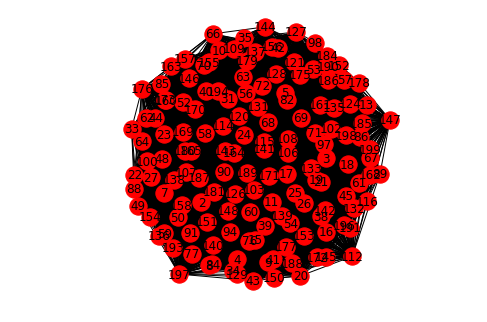

In [5]:
graph = import_graph('DIMACS_all_ascii/brock200_1.clq')
print("The graph contains " + str(len(graph)) + " nodes")
pop = initialize_population(graph, 1)
print("The subgraph contains " + str(len(pop[0])) + " nodes")
print(len(pop[0]))
show_graph(pop[0])

fitness_scores = find_fitnesses(pop)
print(fitness_scores)